In [ ]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score
from xgboost import XGBClassifier
import time
import joblib

#Foarte mica, putin mai mica aici la precision decat la varianta fara l1 si l2
# tot ce avem salvat in foldere sunt bune


In [ ]:
data = pd.read_csv("all_data.csv")


top_20_features = [
    "PSH Flag Count", "Idle Mean", "Total Length of Fwd Packets", "Bwd Packet Length Std",
    "Fwd Packet Length Min", "Total Fwd Packets", "Fwd URG Flags", "act_data_pkt_fwd",
    "Fwd Packet Length Std", "Flow Bytes/s", "Bwd Packets/s", "Total Length of Bwd Packets",
    "Bwd Packet Length Mean", "Average Packet Size", "FIN Flag Count", "Active Std",
    "Total Backward Packets", "Fwd PSH Flags", "Packet Length Mean", "Fwd Packet Length Max",
    "Max Packet Length", "Init_Win_bytes_forward", "Fwd Header Length", "Min Packet Length",
    "Init_Win_bytes_backward", "Bwd Header Length", "Idle Max", "Flow IAT Max",
    "Fwd Packet Length Mean", "min_seg_size_forward", "Bwd IAT Mean", "Packet Length Std",
    "Active Mean", "Packet Length Variance", "Fwd IAT Total", "Fwd IAT Min",
    "Fwd IAT Mean", "ACK Flag Count", "Bwd Packet Length Max", "Flow IAT Std"
]


X = data[top_20_features]
y = data["Label"]

y = y.replace({
    "Heartbleed": "Rare Events",
    "Infiltration": "Rare Events",
    "Web Attack - Brute Force": "Web Attack",
    "Web Attack - XSS": "Web Attack",
    "Web Attack - Sql Injection": "Web Attack"
})

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42)


C:\Users\William\AppData\Local\Temp\ipykernel_20772\2226106642.py:2: DtypeWarning: Columns (84) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("all_data.csv")


In [ ]:

original_counts = pd.Series(y_train).value_counts()
print("Distribuția claselor înainte de SMOTE:", original_counts)

moderate_classes = original_counts[(original_counts >= 1_000) & (original_counts < 100_000)].index
rare_classes = original_counts[original_counts < 1_000].index

smote = SMOTE(
    sampling_strategy={label: int(count * 1.5) for label, count in original_counts.items() if label in moderate_classes},
    random_state=42
)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

for label in rare_classes:
    class_data = X_train_smote[y_train_smote == label]
    class_labels = y_train_smote[y_train_smote == label]

    oversampled_data = resample(
        class_data,
        replace=True,
        n_samples=len(class_data) * 3,
        random_state=42
    )
    oversampled_labels = [label] * len(oversampled_data)

    X_train_smote = pd.concat([pd.DataFrame(X_train_smote), pd.DataFrame(oversampled_data)])
    y_train_smote = pd.concat([pd.Series(y_train_smote), pd.Series(oversampled_labels)])

balanced_counts = Counter(y_train_smote)
print("Distribuția claselor după SMOTE:", balanced_counts)


Distribuția claselor înainte de SMOTE: 0     1651502
4      161751
8      111251
2       29285
3        7205
7        5557
10       4128
6        4057
5        3849
11       1526
1        1376
9          33
Name: count, dtype: int64
Distribuția claselor după SMOTE: Counter({0: 1651502, 4: 161751, 8: 111251, 2: 43927, 3: 10807, 7: 8335, 10: 6192, 6: 6085, 5: 5773, 11: 2289, 1: 2064, 9: 132})


In [ ]:

#returnam gradientul cat de tare a gresit modelul si hesianul (hesian mare nesiguranta)- cat crede modelul in acea predictie, increderea in gradient
   # np.eye(preds.shape[1]) construiește etichetele one-hot.

#preds - y_one_hot = eroarea.

#Se înmulțește cu greutatea instanței.

def weighted_loss(preds, dtrain):
    labels = dtrain.get_label() #label-urile reale
    preds = preds.reshape(len(labels), -1) # predictiile brute,logits
    preds = np.exp(preds) / np.sum(np.exp(preds), axis=1, keepdims=True) #transformare in probabilitati cu softmax

    # cu cat clasele sunt mai mici, cu atat au o greutate mai mare, greselile sunt penalizate mai mult pe acestea rare
    class_weights = {cls: (max(balanced_counts.values()) / count) ** 0.8 for cls, count in balanced_counts.items()} #am folosit factorul de 0.8 pentru a nu penaliza prea mult greselile pe clasele rare, pentru a nu devenii modelul instabil, ar avea recall mare pe clasele rare dar ara fecta precizia
    weight_array = np.array([class_weights[int(label)] for label in labels])

    grad = (preds - np.eye(preds.shape[1])[labels.astype(int)]) * weight_array.reshape(-1, 1)

    hess = preds * (1.0 - preds) * weight_array.reshape(-1, 1)

    return grad.flatten(), hess.flatten()



In [ ]:

def objective(trial):
    max_depth = trial.suggest_int("max_depth", 3, 10)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2)
    n_estimators = trial.suggest_int("n_estimators", 150, 400)
    reg_lambda = trial.suggest_float("reg_lambda", 0.01, 10)  # Regularizare L2
    reg_alpha = trial.suggest_float("reg_alpha", 0.0, 1.0)  # Regularizare L1

    model = XGBClassifier(
        objective="multi:softprob",
        num_class=len(balanced_counts),
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42,
        eval_metric="mlogloss",
        reg_lambda=reg_lambda,  #L2
        reg_alpha=reg_alpha,  # L1
        tree_method = "gpu_hist",
        gpu_id = 0
        
    )

   
    cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train_smote, y_train_smote, cv=cv_strategy, scoring="f1_weighted", n_jobs=-1)

    # Returnam media scorurilor F1 obtinute pe fiecare fold
    return np.mean(scores)

# Optimizam hiperparametrii folosind Optuna
start_time = time.time()
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)
end_time = time.time() 

elapsed_time = end_time - start_time
elapsed_hours = elapsed_time // 3600
elapsed_minutes = (elapsed_time % 3600) // 60
elapsed_seconds = elapsed_time % 60

print(f"Optimizarea cu Optuna a durat {elapsed_hours:.0f} ore, {elapsed_minutes:.0f} minute și {elapsed_seconds:.2f} secunde.")
best_params = study.best_params


[I 2025-02-20 15:59:09,669] A new study created in memory with name: no-name-ecd37d9b-7806-477a-85f4-ee710cbd6530


[I 2025-02-20 16:02:10,998] Trial 0 finished with value: 0.9852957164302363 and parameters: {'max_depth': 10, 'learning_rate': 0.18606005735294479, 'n_estimators': 268, 'reg_lambda': 0.6705497518187872, 'reg_alpha': 0.6376310219955528}. Best is trial 0 with value: 0.9852957164302363.
[I 2025-02-20 16:04:48,021] Trial 1 finished with value: 0.9834485018023443 and parameters: {'max_depth': 6, 'learning_rate': 0.0882031486921208, 'n_estimators': 287, 'reg_lambda': 1.289374811128467, 'reg_alpha': 0.48683165957289853}. Best is trial 0 with value: 0.9852957164302363.
[I 2025-02-20 16:06:03,043] Trial 2 finished with value: 0.9817642023484313 and parameters: {'max_depth': 3, 'learning_rate': 0.1856685034896982, 'n_estimators': 163, 'reg_lambda': 3.0489821999315625, 'reg_alpha': 0.9232429166458531}. Best is trial 0 with value: 0.9852957164302363.
[I 2025-02-20 16:08:11,451] Trial 3 finished with value: 0.9823163628555727 and parameters: {'max_depth': 5, 'learning_rate': 0.06686674698560797, 'n

Optimizarea cu Optuna a durat 0 ore, 53 minute și 21.24 secunde.


In [ ]:
start_train_time = time.time()  

model = xgb.train(
    {
        "objective": "multi:softprob",
        "num_class": len(balanced_counts),
        "max_depth": best_params["max_depth"],
        "learning_rate": best_params["learning_rate"],
        "n_estimators": best_params["n_estimators"],
        "subsample": 0.9,
        "colsample_bytree": 0.9,
        "random_state": 42,
        "tree_method": "gpu_hist",
        "gpu_id": 0,
        "reg_lambda": best_params["reg_lambda"],  # Regularizare L2
        "reg_alpha": best_params["reg_alpha"],  # Regularizare L1
        
    },
    xgb.DMatrix(X_train_smote, label=y_train_smote),
    num_boost_round=best_params["n_estimators"],
    evals=[(xgb.DMatrix(X_test, label=y_test), "eval")],  # Validare in timpul antrenării
    early_stopping_rounds=20,  # Stop antrenare daca nu se mai imbunatateste dupa 20 runde
    obj=weighted_loss
)
end_train_time = time.time() 
elapsed_time = end_train_time - start_train_time
elapsed_hours = elapsed_time // 3600
elapsed_minutes = (elapsed_time % 3600) // 60
elapsed_seconds = elapsed_time % 60

print(f"Antrenarea modelului final a durat {elapsed_hours:.0f} ore, {elapsed_minutes:.0f} minute și {elapsed_seconds:.2f} secunde.")



c:\Users\William\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:11:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)
c:\Users\William\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:11:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\William\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:11:53] WARNING: C:\b

[0]	eval-mlogloss:1.01294
[1]	eval-mlogloss:0.66238
[2]	eval-mlogloss:0.48688
[3]	eval-mlogloss:0.36613
[4]	eval-mlogloss:0.28647
[5]	eval-mlogloss:0.22958
[6]	eval-mlogloss:0.18940
[7]	eval-mlogloss:0.16079
[8]	eval-mlogloss:0.14009
[9]	eval-mlogloss:0.12495
[10]	eval-mlogloss:0.11370
[11]	eval-mlogloss:0.10531
[12]	eval-mlogloss:0.09902
[13]	eval-mlogloss:0.09394
[14]	eval-mlogloss:0.08981
[15]	eval-mlogloss:0.08651
[16]	eval-mlogloss:0.08408
[17]	eval-mlogloss:0.08205
[18]	eval-mlogloss:0.08030
[19]	eval-mlogloss:0.07895
[20]	eval-mlogloss:0.07786
[21]	eval-mlogloss:0.07701
[22]	eval-mlogloss:0.07609
[23]	eval-mlogloss:0.07525
[24]	eval-mlogloss:0.07459
[25]	eval-mlogloss:0.07412
[26]	eval-mlogloss:0.07350
[27]	eval-mlogloss:0.07282
[28]	eval-mlogloss:0.07211
[29]	eval-mlogloss:0.07169
[30]	eval-mlogloss:0.07132
[31]	eval-mlogloss:0.07077
[32]	eval-mlogloss:0.07042
[33]	eval-mlogloss:0.07018
[34]	eval-mlogloss:0.06981
[35]	eval-mlogloss:0.06960
[36]	eval-mlogloss:0.06937
[37]	eval-m

In [ ]:

y_pred_probs = model.predict(xgb.DMatrix(X_test))
y_pred = np.argmax(y_pred_probs, axis=1)


joblib.dump(model, "xgboost_model.pkl")

joblib.dump(label_encoder, "xgboost_label_encoder.pkl")
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

print(f"\n🚀 **Evaluarea Modelului Final Optimizat:**")
print(f"Acuratețea: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")

print("\n📌 **Matricea de Confuzie:**")
print(conf_matrix)

print("\n📊 **Raport de Clasificare:**")
print(class_report)


c:\Users\William\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:20:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



🚀 **Evaluarea Modelului Final Optimizat:**
Acuratețea: 0.9790
F1-Score: 0.9825

📌 **Matricea de Confuzie:**
[[691341    413  15397     19    128    127      8      2    304      3
       6     39]
 [    21    569      0      0      0      0      0      0      0      0
       0      0]
 [  1268      0  11282      0      0      0      0      0      0      0
       0      0]
 [     1      0      0   3084      2      1      0      0      0      0
       0      0]
 [     8      0      0     30  69275      0      0      0      9      0
       0      0]
 [     2      0      0      1      0   1637     10      0      0      0
       0      0]
 [     3      0      0      2      1      3   1729      0      0      0
       0      1]
 [     1      0      0      0      0      0      0   2380      0      0
       0      0]
 [     5      0      0      0     10      0      0      0  47663      0
       0      1]
 [     3      0      0      0      0      0      0      0      0     11
       0      0]
 

In [4]:
%pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score


plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicții")
plt.ylabel("Valori Reale")
plt.title("🔍 Matricea de Confuzie - Model XGBoost Optimizat")
plt.show()



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


NameError: name 'conf_matrix' is not defined

<Figure size 1000x800 with 0 Axes>

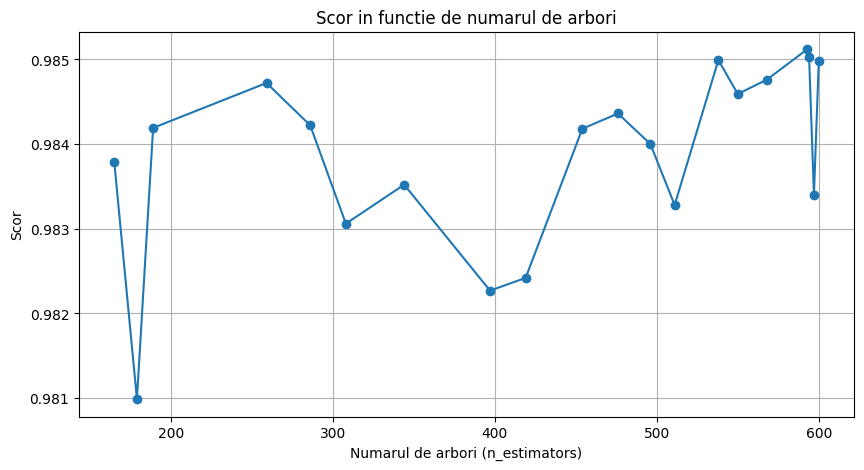

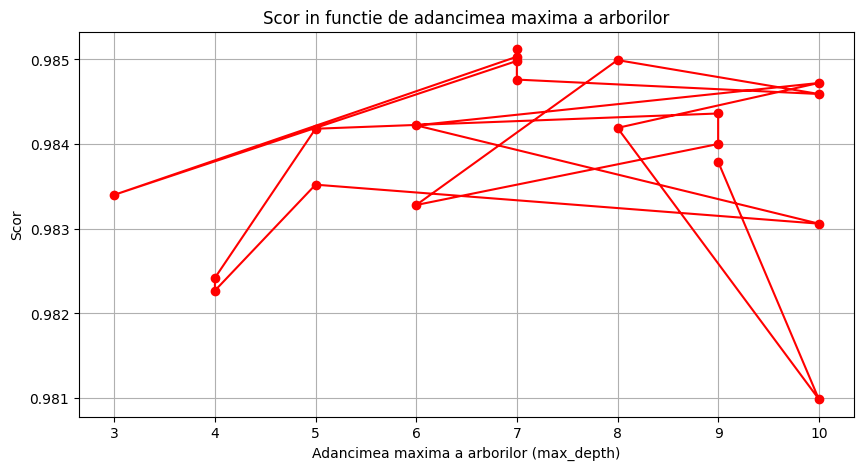

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

# Datele din Optuna (extrase manual din log)
trials_data = [
    (550, 10, 0.98459),
    (189, 8, 0.98419),
    (165, 9, 0.98379),
    (419, 4, 0.98242),
    (476, 9, 0.98436),
    (496, 9, 0.98400),
    (511, 6, 0.98328),
    (179, 10, 0.98099),
    (259, 10, 0.98472),
    (397, 4, 0.98227),
    (286, 6, 0.98422),
    (308, 10, 0.98306),
    (568, 7, 0.98476),
    (594, 7, 0.98503),
    (593, 7, 0.98512),
    (600, 7, 0.98498),
    (454, 5, 0.98418),
    (597, 3, 0.98340),
    (538, 8, 0.98499),
    (344, 5, 0.98352),
]

# Creăm un DataFrame pentru analiză
df = pd.DataFrame(trials_data, columns=["n_estimators", "max_depth", "score"])

# Sortare pentru o mai bună vizualizare a graficelor
df = df.sort_values(by=["n_estimators", "max_depth"])

# Grafic: scor în funcție de numărul de arbori
plt.figure(figsize=(10, 5))
plt.plot(df["n_estimators"], df["score"], marker='o', linestyle='-')
plt.xlabel("Numarul de arbori (n_estimators)")
plt.ylabel("Scor")
plt.title("Scor in functie de numarul de arbori")
plt.grid(True)
plt.show()

# Grafic: scor în funcție de max_depth
plt.figure(figsize=(10, 5))
plt.plot(df["max_depth"], df["score"], marker='o', linestyle='-', color='r')
plt.xlabel("Adancimea maxima a arborilor (max_depth)")
plt.ylabel("Scor")
plt.title("Scor in functie de adancimea maxima a arborilor")
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Datele brute extrase din logurile Optuna (top 20 trial-uri) sa vedem daca il pastrez
trials_data = [
    (268, 10, 0.98530),
    (287, 6, 0.98345),
    (163, 3, 0.98176),
    (259, 5, 0.98232),
    (259, 8, 0.98355),
    (160, 10, 0.98394),
    (192, 5, 0.98217),
    (374, 9, 0.98321),
    (350, 4, 0.98337),
    (323, 3, 0.97882),
    (221, 8, 0.98465),
    (216, 8, 0.98468),
    (240, 10, 0.98504),
    (298, 10, 0.98532),
    (296, 10, 0.98523),
    (318, 7, 0.98463),
    (325, 9, 0.98494),
    (392, 9, 0.98535),
    (395, 9, 0.98503),
    (354, 7, 0.98410)
]

# Creăm DataFrame
df = pd.DataFrame(trials_data, columns=["n_estimators", "max_depth", "score"])

# Identificăm cel mai bun scor
best_trial_idx = df["score"].idxmax()
best_row = df.loc[best_trial_idx]

# Grafic 1: Scor în funcție de n_estimators
plt.figure(figsize=(10, 5))
plt.plot(df["n_estimators"], df["score"], marker='o', linestyle='-')
plt.scatter(best_row["n_estimators"], best_row["score"], color='red', label='Best Trial')
plt.xlabel("Numărul de arbori (n_estimators)")
plt.ylabel("Scor F1")
plt.title("Scor în funcție de numărul de arbori")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Grafic 2: Scor în funcție de max_depth
plt.figure(figsize=(10, 5))
plt.plot(df["max_depth"], df["score"], marker='o', linestyle='-', color='green')
plt.scatter(best_row["max_depth"], best_row["score"], color='red', label='Best Trial')
plt.xlabel("Adâncimea maximă a arborilor (max_depth)")
plt.ylabel("Scor F1")
plt.title("Scor în funcție de adâncimea maximă")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
